In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import spacy
warnings.filterwarnings("ignore")
import random

import nltk
from nltk.stem import WordNetLemmatizer

import re

from spacy.tokens import DocBin

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv(r"C:\Users\sai\Desktop\PRAXIS\Term - 3\CAPP\Datasets\train.csv")
features = pd.read_csv(r"C:\Users\sai\Desktop\PRAXIS\Term - 3\CAPP\Datasets\features.csv")
patient_notes = pd.read_csv(r"C:\Users\sai\Desktop\PRAXIS\Term - 3\CAPP\Datasets\patient_notes.csv")

### CASE - 1

In [3]:
case_1_features = features[features["case_num"] == 1]
case_1_features

,feature_num,case_num,feature_text
13,100,1,No-vaginal-discharge
14,101,1,Weight-loss
15,102,1,Not-sexually-active
16,103,1,Prior-episodes-of-diarrhea
17,104,1,20-year
18,105,1,No-bloody-bowel-movements
19,106,1,Recurrent-bouts-over-past-6-months
20,107,1,Right-sided-LQ-abdominal-pain-OR-Right-lower-q...
21,108,1,No-urinary-symptoms
22,109,1,Diminished-appetite


In [4]:
case_1_pn = patient_notes[patient_notes["case_num"] ==  1]
case_1_pn

,pn_num,case_num,pn_history
2268,10000,1,Ms. Suzanne Powelton is a 20 y/o F that presen...
2269,10001,1,Suzanne Powelton is a 20 year old woman who pr...
2270,10002,1,HPI: 20 yo f c/o constant worsening right lowe...
2271,10004,1,20 y/o F c/o abdominal pain \r\n5/10. from la...
2272,10005,1,20 YO F came to the ED complaining of Right lo...
...,...,...,...
3071,10986,1,suzanne is a 20 year old woman who presents wi...
3072,10987,1,Ms. 20yo wiht no PMH presenting with concerns ...
3073,10988,1,HPI: 20 yo F c/o RLQ pain for past 10 hrs. 5/1...
3074,10989,1,Ms. Powelton is a 20 yo female presenting with...


In [5]:
case_1_train = train_data[train_data["case_num"] == 1]
case_1_train = case_1_train[case_1_train.annotation != '[]']
case_1_train.head()

,id,case_num,pn_num,feature_num,annotation,location
1300,10004_100,1,10004,100,['no discharge'],['206 218']
1302,10004_102,1,10004,102,['last sexual encounter 9 months ago'],['529 563']
1304,10004_104,1,10004,104,['20 y/o'],['0 6']
1306,10004_106,1,10004,106,['similar episodes 3-4 in the last 6 months'],['265 306']
1307,10004_107,1,10004,107,['pain in the right lower quadrant'],['82 114']


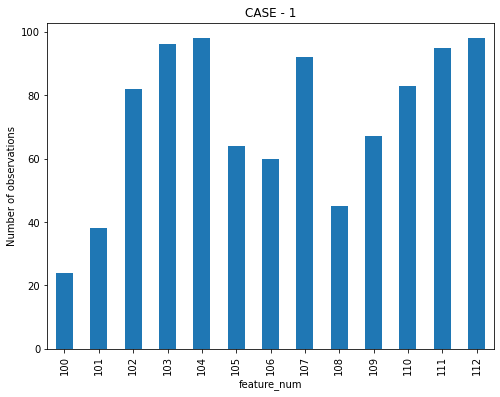

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
case_1_train.groupby("feature_num").size().plot.bar()
plt.title("CASE - 1")
plt.ylabel("Number of observations")
plt.show()

### Over Sampling for CASE - 1

In [7]:
pn_dict = {}
for idx, row in case_1_pn.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [8]:
new_annotation = []
for case_id in case_1_features['case_num'].unique():
    
    all_pn_id = set(case_1_pn[case_1_pn['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in case_1_features[case_1_features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(case_1_train[case_1_train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = case_1_train[case_1_train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
     #   break
    break
    # break to get sample results quickly

In [9]:
len(new_annotation)

4629

In [10]:
df=pd.DataFrame(new_annotation)
df.head()

,0,1,2,3,4,5
0,10255_100,1,10255,100,[No vaginal discharge],[546 566]
1,10257_100,1,10257,100,[Denies vaginal discharge],[355 379]
2,10259_100,1,10259,100,[Denies vaginal discharge],[654 678]
3,10290_100,1,10290,100,[no vaginal discharge],[376 396]
4,10307_100,1,10307,100,[No vaginal discharge],[419 439]


In [11]:
df.columns=['id','case_num','pn_num','feature_num','annotation','location']
df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,10255_100,1,10255,100,[No vaginal discharge],[546 566]
1,10257_100,1,10257,100,[Denies vaginal discharge],[355 379]
2,10259_100,1,10259,100,[Denies vaginal discharge],[654 678]
3,10290_100,1,10290,100,[no vaginal discharge],[376 396]
4,10307_100,1,10307,100,[No vaginal discharge],[419 439]


In [12]:
df["location"] = df["location"].apply(str)
df["annotation"] = df["annotation"].apply(str)

df["annotation"] = df.annotation.str.replace('[','')
df["annotation"] = df.annotation.str.replace(']','')
df["location"] = df.location.str.replace('[','')
df["location"] = df.location.str.replace(']','')

df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,10255_100,1,10255,100,'No vaginal discharge','546 566'
1,10257_100,1,10257,100,'Denies vaginal discharge','355 379'
2,10259_100,1,10259,100,'Denies vaginal discharge','654 678'
3,10290_100,1,10290,100,'no vaginal discharge','376 396'
4,10307_100,1,10307,100,'No vaginal discharge','419 439'


In [13]:
df = df[(df["feature_num"] == 100)|(df["feature_num"] == 101)|(df["feature_num"] == 102)|(df["feature_num"] == 105)|(df["feature_num"] == 106)|(df["feature_num"] == 108)|(df["feature_num"] == 109)][['pn_num','annotation',"location","feature_num"]]
df.shape

(1171, 4)

In [14]:
df = (df.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df.columns, axis=1))
df

,pn_num,annotation,location,feature_num
0,10255,'No vaginal discharge','546 566',100
1,10257,'Denies vaginal discharge','355 379',100
2,10259,'Denies vaginal discharge','654 678',100
3,10290,'no vaginal discharge','376 396',100
4,10307,'No vaginal discharge','419 439',100
...,...,...,...,...
1482,10215,'anorexia','464 472',109
1483,10225,'no appetite','329 340',109
1484,10234,'poor appetite','352 365',109
1485,10237,'decreased appetite','583 601',109


In [15]:
df["start_location"] = df["location"].apply(lambda x: x.split()[0][1:])
df["end_location"] = df["location"].apply(lambda x: x.split()[-1][:-1])
df

,pn_num,annotation,location,feature_num,start_location,end_location
0,10255,'No vaginal discharge','546 566',100,546,566
1,10257,'Denies vaginal discharge','355 379',100,355,379
2,10259,'Denies vaginal discharge','654 678',100,654,678
3,10290,'no vaginal discharge','376 396',100,376,396
4,10307,'No vaginal discharge','419 439',100,419,439
...,...,...,...,...,...,...
1482,10215,'anorexia','464 472',109,464,472
1483,10225,'no appetite','329 340',109,329,340
1484,10234,'poor appetite','352 365',109,352,365
1485,10237,'decreased appetite','583 601',109,583,601


In [16]:
df_100 = df[df["feature_num"] == 100]
df_100.shape

(80, 6)

In [17]:
df_101 = df[df["feature_num"] == 101].sample(n = 50, random_state = 100)
df_101.shape

(50, 6)

In [18]:
df_102 = df[df["feature_num"] == 102].sample(n = 60, random_state = 100)
df_102.shape

(60, 6)

In [19]:
df_105 = df[df["feature_num"] == 105].sample(n = 60, random_state = 100)
df_105.shape

(60, 6)

In [20]:
df_106 = df[df["feature_num"] == 106].sample(n = 50, random_state = 100)
df_106.shape

(50, 6)

In [21]:
df_108 = df[df["feature_num"] == 108].sample(n = 41, random_state = 100)
df_108.shape

(41, 6)

In [22]:
df_109 = df[df["feature_num"] == 109].sample(n = 40, random_state = 100)
df_109.shape

(40, 6)

### Case - 1 Train data

In [23]:
case_1_train = case_1_train[['pn_num','annotation',"location","feature_num"]]

In [24]:
case_1_train["annotation"] = case_1_train.annotation.str.replace('[','')
case_1_train["annotation"] = case_1_train.annotation.str.replace(']','')
case_1_train["location"] = case_1_train.location.str.replace('[','')
case_1_train["location"] = case_1_train.location.str.replace(']','')

case_1_train

,pn_num,annotation,location,feature_num
1300,10004,'no discharge','206 218',100
1302,10004,'last sexual encounter 9 months ago','529 563',102
1304,10004,'20 y/o','0 6',104
1306,10004,'similar episodes 3-4 in the last 6 months','265 306',106
1307,10004,'pain in the right lower quadrant','82 114',107
...,...,...,...,...
2594,10988,'RLQ pain','17 25',107
2596,10988,'loss of appetite','376 392',109
2597,10988,"'LMP was 2 wks ago', 'LMP 2wks ago'","'459 476', '665 677'",110
2598,10988,'10 hrs','35 41',111


In [25]:
case_1_train.loc[case_1_train["annotation"] =="'stool , with no blood'", "annotation"] = "'stool   with no blood'"
case_1_train.loc[case_1_train["annotation"] =="'diarrhea, which does not contain blood'","annotation"] = "'diarrhea  which does not contain blood'"
case_1_train.loc[case_1_train["annotation"] =="'3-4 similar, previous episodes of pain'"] = "'3-4 similar  previous episodes of pain'"
case_1_train.loc[case_1_train["annotation"] =="'diarrhea', 'loose, watery stool'","annotation"] = "'diarrhea', 'loose  watery stool'"
case_1_train.loc[case_1_train["annotation"] =="'LMP: 2WK, REGULAR'","annotation"] = "'LMP: 2WK  REGULAR'"
case_1_train.loc[case_1_train["annotation"] =="'sexual active, last time was 9 months ago'","annotation"] = "'sexual active  last time was 9 months ago'"
case_1_train.loc[case_1_train["annotation"] =="'pain, started 8-10 hours ago'","annotation"] = "'pain  started 8-10 hours ago'"
case_1_train.loc[case_1_train["annotation"] =="'diarrhea in the past 2 days', 'soft, watery stools'","annotation"] = "'diarrhea in the past 2 days', 'soft  watery stools'"

In [26]:
case_1_train = (case_1_train.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(case_1_train.columns, axis=1))
case_1_train

,pn_num,annotation,location,feature_num
0,10004,'no discharge','206 218',100
1,10004,'last sexual encounter 9 months ago','529 563',102
2,10004,'20 y/o','0 6',104
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106
4,10004,'pain in the right lower quadrant','82 114',107
...,...,...,...,...
1024,10988,'loss of appetite','376 392',109
1025,10988,'LMP was 2 wks ago','459 476',110
1026,10988,'LMP 2wks ago','665 677',110
1027,10988,'10 hrs','35 41',111


In [27]:
case_1_train = case_1_train.drop(index = 433, axis = 0)

In [28]:
case_1_train["start_location"] = case_1_train["location"].apply(lambda x: x.split()[0][1:])
case_1_train["end_location"] = case_1_train["location"].apply(lambda x: x.split()[-1][:-1])
case_1_train

,pn_num,annotation,location,feature_num,start_location,end_location
0,10004,'no discharge','206 218',100,206,218
1,10004,'last sexual encounter 9 months ago','529 563',102,529,563
2,10004,'20 y/o','0 6',104,0,6
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106,265,306
4,10004,'pain in the right lower quadrant','82 114',107,82,114
...,...,...,...,...,...,...
1024,10988,'loss of appetite','376 392',109,376,392
1025,10988,'LMP was 2 wks ago','459 476',110,459,476
1026,10988,'LMP 2wks ago','665 677',110,665,677
1027,10988,'10 hrs','35 41',111,35,41


In [29]:
case_1 = pd.concat([case_1_train, df_100, df_101, df_108,df_102, df_105, df_106, df_109])
case_1.shape

(1409, 6)

In [30]:
case_1 = case_1.merge(patient_notes, on='pn_num', how='left')
case_1

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history
0,10004,'no discharge','206 218',100,206,218,1,20 y/o F c/o abdominal pain \r\n5/10. from la...
1,10004,'last sexual encounter 9 months ago','529 563',102,529,563,1,20 y/o F c/o abdominal pain \r\n5/10. from la...
2,10004,'20 y/o','0 6',104,0,6,1,20 y/o F c/o abdominal pain \r\n5/10. from la...
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106,265,306,1,20 y/o F c/o abdominal pain \r\n5/10. from la...
4,10004,'pain in the right lower quadrant','82 114',107,82,114,1,20 y/o F c/o abdominal pain \r\n5/10. from la...
...,...,...,...,...,...,...,...,...
1404,10791,'anorexia','347 355',109,347,355,1,This is a 20 year old female who presents for ...
1405,10706,'decreased appetite','143 161',109,143,161,1,20 year old female presents with sudden onset ...
1406,10918,'anorexia','408 416',109,408,416,1,Ms Powelton is a 20 yo F with no PMH presentin...
1407,10452,'Loss of appetite','273 289',109,273,289,1,HPI 20 yo F complains of lower righ abdominal ...


In [31]:
case_1["New_annotation"] = case_1.apply(lambda x: x.pn_history[int(x.start_location):int(x.end_location)],axis=1)
case_1.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,10004,'no discharge','206 218',100,206,218,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,no discharge
1,10004,'last sexual encounter 9 months ago','529 563',102,529,563,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,last sexual encounter 9 months ago
2,10004,'20 y/o','0 6',104,0,6,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,20 y/o
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106,265,306,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,similar episodes 3-4 in the last 6 months
4,10004,'pain in the right lower quadrant','82 114',107,82,114,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,pain in the right lower quadrant


In [32]:
case_1["New_annotation"] = case_1["New_annotation"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
case_1["New_annotation"] = case_1["New_annotation"].apply(lambda x: re.sub(r'''[']''','',x))
case_1["New_annotation"] = case_1["New_annotation"].apply(lambda x: x.strip())
case_1

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,10004,'no discharge','206 218',100,206,218,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,no discharge
1,10004,'last sexual encounter 9 months ago','529 563',102,529,563,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,last sexual encounter 9 months ago
2,10004,'20 y/o','0 6',104,0,6,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,20 y o
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106,265,306,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,similar episodes 3-4 in the last 6 months
4,10004,'pain in the right lower quadrant','82 114',107,82,114,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,pain in the right lower quadrant
...,...,...,...,...,...,...,...,...,...
1404,10791,'anorexia','347 355',109,347,355,1,This is a 20 year old female who presents for ...,anorexia
1405,10706,'decreased appetite','143 161',109,143,161,1,20 year old female presents with sudden onset ...,decreased appetite
1406,10918,'anorexia','408 416',109,408,416,1,Ms Powelton is a 20 yo F with no PMH presentin...,anorexia
1407,10452,'Loss of appetite','273 289',109,273,289,1,HPI 20 yo F complains of lower righ abdominal ...,Loss of appetite


In [33]:
case_1["New_pn_history"] = case_1["pn_history"].apply(lambda x: re.sub(r'''[/",+()\r\n]''',' ',x))
case_1["New_pn_history"] = case_1["New_pn_history"].apply(lambda x: re.sub(r'''[']''','',x))
case_1

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,10004,'no discharge','206 218',100,206,218,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,no discharge,20 y o F c o abdominal pain 5 10. from last...
1,10004,'last sexual encounter 9 months ago','529 563',102,529,563,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,last sexual encounter 9 months ago,20 y o F c o abdominal pain 5 10. from last...
2,10004,'20 y/o','0 6',104,0,6,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,20 y o,20 y o F c o abdominal pain 5 10. from last...
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106,265,306,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,similar episodes 3-4 in the last 6 months,20 y o F c o abdominal pain 5 10. from last...
4,10004,'pain in the right lower quadrant','82 114',107,82,114,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,pain in the right lower quadrant,20 y o F c o abdominal pain 5 10. from last...
...,...,...,...,...,...,...,...,...,...,...
1404,10791,'anorexia','347 355',109,347,355,1,This is a 20 year old female who presents for ...,anorexia,This is a 20 year old female who presents for ...
1405,10706,'decreased appetite','143 161',109,143,161,1,20 year old female presents with sudden onset ...,decreased appetite,20 year old female presents with sudden onset ...
1406,10918,'anorexia','408 416',109,408,416,1,Ms Powelton is a 20 yo F with no PMH presentin...,anorexia,Ms Powelton is a 20 yo F with no PMH presentin...
1407,10452,'Loss of appetite','273 289',109,273,289,1,HPI 20 yo F complains of lower righ abdominal ...,Loss of appetite,HPI 20 yo F complains of lower righ abdominal ...


In [34]:
def word_lemm(sentence):
    word_list = nltk.word_tokenize(sentence)
    
    lemmaztier = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmaztier.lemmatize(w) for w in word_list])
    return(lemmatized_output)

In [35]:
case_1["New_annotation"] = case_1["New_annotation"].apply(word_lemm)
case_1["New_pn_history"] = case_1["New_pn_history"].apply(word_lemm)
case_1.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,10004,'no discharge','206 218',100,206,218,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,no discharge,20 y o F c o abdominal pain 5 10. from last 10...
1,10004,'last sexual encounter 9 months ago','529 563',102,529,563,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,last sexual encounter 9 month ago,20 y o F c o abdominal pain 5 10. from last 10...
2,10004,'20 y/o','0 6',104,0,6,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,20 y o,20 y o F c o abdominal pain 5 10. from last 10...
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106,265,306,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,similar episode 3-4 in the last 6 month,20 y o F c o abdominal pain 5 10. from last 10...
4,10004,'pain in the right lower quadrant','82 114',107,82,114,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,pain in the right lower quadrant,20 y o F c o abdominal pain 5 10. from last 10...


In [36]:
case_1["new_location"] = case_1.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history),axis =1)
case_1

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,10004,'no discharge','206 218',100,206,218,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,no discharge,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(201, 213), match='no d..."
1,10004,'last sexual encounter 9 months ago','529 563',102,529,563,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,last sexual encounter 9 month ago,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(519, 552), match='last..."
2,10004,'20 y/o','0 6',104,0,6,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,20 y o,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(0, 6), match='20 y o'>"
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106,265,306,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,similar episode 3-4 in the last 6 month,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(260, 299), match='simi..."
4,10004,'pain in the right lower quadrant','82 114',107,82,114,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,pain in the right lower quadrant,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(79, 111), match='pain ..."
...,...,...,...,...,...,...,...,...,...,...,...
1404,10791,'anorexia','347 355',109,347,355,1,This is a 20 year old female who presents for ...,anorexia,This is a 20 year old female who present for e...,"<re.Match object; span=(345, 353), match='anor..."
1405,10706,'decreased appetite','143 161',109,143,161,1,20 year old female presents with sudden onset ...,decreased appetite,20 year old female present with sudden onset R...,"<re.Match object; span=(140, 158), match='decr..."
1406,10918,'anorexia','408 416',109,408,416,1,Ms Powelton is a 20 yo F with no PMH presentin...,anorexia,Ms Powelton is a 20 yo F with no PMH presentin...,"<re.Match object; span=(406, 414), match='anor..."
1407,10452,'Loss of appetite','273 289',109,273,289,1,HPI 20 yo F complains of lower righ abdominal ...,Loss of appetite,HPI 20 yo F complains of lower righ abdominal ...,"<re.Match object; span=(273, 289), match='Loss..."


In [37]:
drop_index = []
for  index,row in case_1.iterrows():
    if row["new_location"] == None:
        drop_index.append(index)
        
print(drop_index),len(drop_index)

[100, 122, 233, 234, 240, 241, 290, 297, 331, 659, 708, 1001, 1145, 1203, 1208, 1216, 1240, 1253, 1257, 1258, 1323, 1332]


(None, 22)

In [38]:
case_1 = case_1.drop(drop_index,axis = 0)
case_1

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,10004,'no discharge','206 218',100,206,218,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,no discharge,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(201, 213), match='no d..."
1,10004,'last sexual encounter 9 months ago','529 563',102,529,563,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,last sexual encounter 9 month ago,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(519, 552), match='last..."
2,10004,'20 y/o','0 6',104,0,6,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,20 y o,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(0, 6), match='20 y o'>"
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106,265,306,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,similar episode 3-4 in the last 6 month,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(260, 299), match='simi..."
4,10004,'pain in the right lower quadrant','82 114',107,82,114,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,pain in the right lower quadrant,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(79, 111), match='pain ..."
...,...,...,...,...,...,...,...,...,...,...,...
1404,10791,'anorexia','347 355',109,347,355,1,This is a 20 year old female who presents for ...,anorexia,This is a 20 year old female who present for e...,"<re.Match object; span=(345, 353), match='anor..."
1405,10706,'decreased appetite','143 161',109,143,161,1,20 year old female presents with sudden onset ...,decreased appetite,20 year old female present with sudden onset R...,"<re.Match object; span=(140, 158), match='decr..."
1406,10918,'anorexia','408 416',109,408,416,1,Ms Powelton is a 20 yo F with no PMH presentin...,anorexia,Ms Powelton is a 20 yo F with no PMH presentin...,"<re.Match object; span=(406, 414), match='anor..."
1407,10452,'Loss of appetite','273 289',109,273,289,1,HPI 20 yo F complains of lower righ abdominal ...,Loss of appetite,HPI 20 yo F complains of lower righ abdominal ...,"<re.Match object; span=(273, 289), match='Loss..."


In [39]:
case_1["start_location"] = case_1.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).start(),axis =1)
case_1["end_location"] = case_1.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).end(),axis =1)
case_1

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,10004,'no discharge','206 218',100,201,213,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,no discharge,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(201, 213), match='no d..."
1,10004,'last sexual encounter 9 months ago','529 563',102,519,552,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,last sexual encounter 9 month ago,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(519, 552), match='last..."
2,10004,'20 y/o','0 6',104,0,6,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,20 y o,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(0, 6), match='20 y o'>"
3,10004,'similar episodes 3-4 in the last 6 months','265 306',106,260,299,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,similar episode 3-4 in the last 6 month,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(260, 299), match='simi..."
4,10004,'pain in the right lower quadrant','82 114',107,79,111,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,pain in the right lower quadrant,20 y o F c o abdominal pain 5 10. from last 10...,"<re.Match object; span=(79, 111), match='pain ..."
...,...,...,...,...,...,...,...,...,...,...,...
1404,10791,'anorexia','347 355',109,345,353,1,This is a 20 year old female who presents for ...,anorexia,This is a 20 year old female who present for e...,"<re.Match object; span=(345, 353), match='anor..."
1405,10706,'decreased appetite','143 161',109,140,158,1,20 year old female presents with sudden onset ...,decreased appetite,20 year old female present with sudden onset R...,"<re.Match object; span=(140, 158), match='decr..."
1406,10918,'anorexia','408 416',109,406,414,1,Ms Powelton is a 20 yo F with no PMH presentin...,anorexia,Ms Powelton is a 20 yo F with no PMH presentin...,"<re.Match object; span=(406, 414), match='anor..."
1407,10452,'Loss of appetite','273 289',109,273,289,1,HPI 20 yo F complains of lower righ abdominal ...,Loss of appetite,HPI 20 yo F complains of lower righ abdominal ...,"<re.Match object; span=(273, 289), match='Loss..."


In [40]:
case_1 = case_1.drop(index = 261, axis = 0)
case_1 = case_1.drop(index = 1018, axis = 0)
case_1 = case_1.drop(index = 46, axis = 0)
case_1 = case_1.drop(index = 114, axis = 0)
case_1 = case_1.drop(index = [264,265], axis = 0)
case_1 = case_1.drop(index = 312, axis = 0)
case_1 = case_1.drop(index = 431, axis = 0)
case_1 = case_1.drop(index = 536, axis = 0)
case_1 = case_1.drop(index = 780, axis = 0)
case_1 = case_1.drop(index = 932, axis = 0)
case_1 = case_1.drop(index = 381, axis = 0)
case_1 = case_1.drop(index = 482, axis = 0)
case_1 = case_1.drop(index = 496, axis = 0)
case_1 = case_1.drop(index = 662, axis = 0)
case_1 = case_1.drop(index = 957, axis = 0)
case_1 = case_1.drop(index = 106, axis = 0)
case_1 = case_1.drop(index = 317, axis = 0)
case_1 = case_1.drop(index = 605, axis = 0)
case_1 = case_1.drop(index = 38, axis = 0)
case_1 = case_1.drop(index = 108, axis = 0)
case_1 = case_1.drop(index = 148, axis = 0)
case_1 = case_1.drop(index = 371, axis = 0)
case_1 = case_1.drop(index = 405, axis = 0)
case_1 = case_1.drop(index = [486,485], axis = 0)
case_1 = case_1.drop(index = 999, axis = 0)
case_1 = case_1.drop(index = 938, axis = 0)
case_1 = case_1.drop(index = [1009,1008], axis = 0)
case_1 = case_1.drop(index = 319, axis = 0)
case_1 = case_1.drop(index = 500, axis = 0)
case_1 = case_1.drop(index = 1231, axis = 0)
case_1 = case_1.drop(index = 1325, axis = 0)
case_1 = case_1.drop(index = 1333, axis = 0)
case_1 = case_1.drop(index = 1346, axis = 0)
case_1 = case_1.drop(index = 1359, axis = 0)

### Feature 100

In [41]:
case_1_100 = case_1[case_1["feature_num"] == 100]
case_1_100.shape

(104, 11)

In [42]:
pn_Num_list = list(case_1_100.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_100[case_1_100.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_100[case_1_100.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_100.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_100.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(83, 21)

In [43]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_100.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 319.07it/s]


In [44]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_100.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 418.27it/s]


In [45]:
!python -m spacy init fill-config ./base_config_100.cfg ./config_100.cfg

[+] Auto-filled config with all values
[+] Saved config
config_100.cfg
You can now add your data and train your pipeline:
python -m spacy train config_100.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 11:45:30.481078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 11:45:30.481139: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [46]:
!python -m spacy train config_100.cfg --output ./output_100

[i] Saving to output directory: output_100
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     46.00    0.00    0.00    0.00    0.00
  2     200        231.78   1420.72   60.00   63.16   57.14    0.60
  4     400         63.54     70.39   53.33   50.00   57.14    0.53
  7     600         32.16     41.20   95.24   95.24   95.24    0.95
  9     800         55.03     38.15   90.91   86.96   95.24    0.91
 12    1000         24.01     21.89   95.24   95.24   95.24    0.95
 14    1200         33.66     16.77   92.68   95.00   90.48    0.93
 16    1400          9.81     14.75   90.00   94.74   85.71    0.90
 19    1600      

2022-05-02 11:45:41.760952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 11:45:41.761037: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 11:45:52,097] [INFO] Set up nlp object from config
[2022-05-02 11:45:52,119] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 11:45:52,131] [INFO] Created vocabulary
[2022-05-02 11:45:52,133] [INFO] Finished initializing nlp object
[2022-05-02 11:45:53,417] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 101

In [47]:
case_1_101 = case_1[case_1["feature_num"] == 101]
case_1_101.shape

(96, 11)

In [48]:
pn_Num_list = list(case_1_101.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_101[case_1_101.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_101[case_1_101.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_101.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_101.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(69, 18)

In [49]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_101.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 313.66it/s]


In [50]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_101.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 440.48it/s]


In [51]:
!python -m spacy init fill-config ./base_config_101.cfg ./config_101.cfg

[+] Auto-filled config with all values
[+] Saved config
config_101.cfg
You can now add your data and train your pipeline:
python -m spacy train config_101.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 11:49:56.144598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 11:49:56.144651: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [52]:
!python -m spacy train config_101.cfg --output ./output_101

[i] Saving to output directory: output_101
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     66.00    0.00    0.00    0.00    0.00
  2     200       7029.81   1592.83   66.67   65.22   68.18    0.67
  5     400        253.56     47.08   80.95   85.00   77.27    0.81
  8     600         18.18     20.06   75.00   83.33   68.18    0.75
 11     800          9.17      9.39   71.43   75.00   68.18    0.71
 14    1000          1.57      1.78   73.17   78.95   68.18    0.73
 17    1200          0.00      0.00   74.42   76.19   72.73    0.74
 20    1400          0.00      0.00   74.42   76.19   72.73    0.74
 23    1600      

2022-05-02 11:50:02.885248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 11:50:02.885299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 11:50:07,275] [INFO] Set up nlp object from config
[2022-05-02 11:50:07,285] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 11:50:07,289] [INFO] Created vocabulary
[2022-05-02 11:50:07,290] [INFO] Finished initializing nlp object
[2022-05-02 11:50:07,867] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 102

In [53]:
case_1_102 = case_1[case_1["feature_num"] == 102]
case_1_102.shape

(139, 11)

In [54]:
pn_Num_list = list(case_1_102.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_102[case_1_102.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_102[case_1_102.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_102.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_102.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(105, 27)

In [55]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_102.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 334.44it/s]

Skipping entity
Skipping entity


In [56]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_102.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 511.15it/s]


In [57]:
!python -m spacy init fill-config ./base_config_102.cfg ./config_102.cfg

[+] Auto-filled config with all values
[+] Saved config
config_102.cfg
You can now add your data and train your pipeline:
python -m spacy train config_102.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 11:54:06.337682: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 11:54:06.337806: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [58]:
!python -m spacy train config_102.cfg --output ./output_102

[i] Saving to output directory: output_102
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     64.00    0.00    0.00    0.00    0.00
  1     200        357.58   1758.53   50.98   61.90   43.33    0.51
  3     400         42.23    158.71   70.00   70.00   70.00    0.70
  5     600         72.14    119.89   77.19   81.48   73.33    0.77
  7     800         74.78    100.91   71.70   82.61   63.33    0.72
  9    1000         87.07     80.08   52.83   60.87   46.67    0.53
 11    1200         52.60     49.70   50.98   61.90   43.33    0.51
 13    1400         73.05     61.25   72.41   75.00   70.00    0.72
 15    1600      

2022-05-02 11:54:13.259305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 11:54:13.259366: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 11:54:17,555] [INFO] Set up nlp object from config
[2022-05-02 11:54:17,565] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 11:54:17,569] [INFO] Created vocabulary
[2022-05-02 11:54:17,570] [INFO] Finished initializing nlp object
[2022-05-02 11:54:18,328] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 103

In [59]:
case_1_103 = case_1[case_1["feature_num"] == 103]
case_1_103.shape

(113, 11)

In [60]:
pn_Num_list = list(case_1_103.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_103[case_1_103.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_103[case_1_103.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_103.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_103.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(76, 20)

In [61]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_103.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 338.91it/s]

Skipping entity


In [62]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_103.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 418.07it/s]


In [63]:
!python -m spacy init fill-config ./base_config_103.cfg ./config_103.cfg

[+] Auto-filled config with all values
[+] Saved config
config_103.cfg
You can now add your data and train your pipeline:
python -m spacy train config_103.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 11:58:46.547478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 11:58:46.547536: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [64]:
!python -m spacy train config_103.cfg --output ./output_103

[i] Saving to output directory: output_103
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     49.33    0.00    0.00    0.00    0.00
  2     200        414.56   1645.95   25.00   26.09   24.00    0.25
  5     400         34.53    237.39   17.78   20.00   16.00    0.18
  7     600         66.78    171.74   13.04   14.29   12.00    0.13
 10     800         76.64    106.11   21.74   23.81   20.00    0.22
 13    1000         69.62     54.09   24.39   31.25   20.00    0.24
 15    1200         88.08     47.75   22.64   21.43   24.00    0.23
 18    1400         71.76     29.87   16.33   16.67   16.00    0.16
 21    1600      

2022-05-02 11:58:55.077142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 11:58:55.077223: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 11:59:00,950] [INFO] Set up nlp object from config
[2022-05-02 11:59:00,973] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 11:59:00,981] [INFO] Created vocabulary
[2022-05-02 11:59:00,983] [INFO] Finished initializing nlp object
[2022-05-02 11:59:01,784] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 104

In [65]:
case_1_104 = case_1[case_1["feature_num"] == 104]
case_1_104.shape

(95, 11)

In [66]:
pn_Num_list = list(case_1_104.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_104[case_1_104.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_104[case_1_104.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_104.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_104.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(76, 19)

In [67]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_104.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 271.37it/s]


In [68]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_104.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 488.80it/s]


In [69]:
!python -m spacy init fill-config ./base_config_104.cfg ./config_104.cfg

[+] Auto-filled config with all values
[+] Saved config
config_104.cfg
You can now add your data and train your pipeline:
python -m spacy train config_104.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 12:03:15.647056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:03:15.647110: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [70]:
!python -m spacy train config_104.cfg --output ./output_104

[i] Saving to output directory: output_104

2022-05-02 12:03:24.175886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:03:24.175941: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 12:03:29,927] [INFO] Set up nlp object from config
[2022-05-02 12:03:29,948] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 12:03:29,957] [INFO] Created vocabulary
[2022-05-02 12:03:29,958] [INFO] Finished initializing nlp object
[2022-05-02 12:03:30,709] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     67.33    0.00    0.00    0.00    0.00
  2     200      24838.60   2668.12   86.49   88.89   84.21    0.86
  5     400         16.39     45.95   86.49   88.89   84.21    0.86
  7     600         16.38     46.28   84.21   84.21   84.21    0.84
 10     800         91.36     57.92   86.49   88.89   84.21    0.86
 13    1000          9.50     34.67   84.21   84.21   84.21    0.84
 15    1200         18.30     39.85   84.21   84.21   84.21    0.84
 18    1400         14.72     32.89   82.05   80.00   84.21    0.82
 21    1600         25.22     51.43   78.95   78.95   78.95

### Feature 105

In [71]:
case_1_105 = case_1[case_1["feature_num"] == 105]
case_1_105.shape

(127, 11)

In [72]:
pn_Num_list = list(case_1_105.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_105[case_1_105.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_105[case_1_105.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_105.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_105.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(99, 25)

In [73]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_105.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 309.14it/s]


In [74]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_105.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 557.34it/s]


In [75]:
!python -m spacy init fill-config ./base_config_105.cfg ./config_105.cfg

[+] Auto-filled config with all values

2022-05-02 12:07:24.957780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:07:24.957857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_105.cfg
You can now add your data and train your pipeline:
python -m spacy train config_105.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [76]:
!python -m spacy train config_105.cfg --output ./output_105

[i] Saving to output directory: output_105
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     53.83    0.00    0.00    0.00    0.00
  2     200        397.91   1693.26   68.00   73.91   62.96    0.68
  4     400         91.40    160.84   54.24   50.00   59.26    0.54
  6     600        112.14     97.83   57.69   60.00   55.56    0.58
  8     800        136.06     83.48   50.91   50.00   51.85    0.51
 10    1000         63.04     65.31   65.31   72.73   59.26    0.65
 12    1200         44.69     22.07   52.00   56.52   48.15    0.52
 14    1400         67.49     25.95   61.54   64.00   59.26    0.62
 16    1600      

2022-05-02 12:07:32.922967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:07:32.923035: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 12:07:38,456] [INFO] Set up nlp object from config
[2022-05-02 12:07:38,474] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 12:07:38,478] [INFO] Created vocabulary
[2022-05-02 12:07:38,480] [INFO] Finished initializing nlp object
[2022-05-02 12:07:39,282] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 106

In [77]:
case_1_106 = case_1[case_1["feature_num"] == 106]
case_1_106.shape

(106, 11)

In [78]:
pn_Num_list = list(case_1_106.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_106[case_1_106.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_106[case_1_106.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_106.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_106.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(82, 21)

In [79]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_106.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 360.08it/s]


In [80]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_106.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 468.21it/s]


In [81]:
!python -m spacy init fill-config ./base_config_106.cfg ./config_106.cfg

[+] Auto-filled config with all values
[+] Saved config
config_106.cfg
You can now add your data and train your pipeline:
python -m spacy train config_106.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 12:11:33.370808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:11:33.370878: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [82]:
!python -m spacy train config_106.cfg --output ./output_106

[i] Saving to output directory: output_106
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.00    1.59    0.97    4.35    0.02
  2     200        889.76   1477.47    0.00    0.00    0.00    0.00
  4     400        234.24    366.05   19.61   17.86   21.74    0.20
  7     600         70.49    289.74   38.10   42.11   34.78    0.38
  9     800        151.21    225.51   32.56   35.00   30.43    0.33
 12    1000         98.07    178.50   23.81   26.32   21.74    0.24
 14    1200        141.88    173.55   39.02   44.44   34.78    0.39
 17    1400        169.70    172.00   34.04   33.33   34.78    0.34
 19    1600      

2022-05-02 12:11:40.541495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:11:40.541568: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 12:11:46,846] [INFO] Set up nlp object from config
[2022-05-02 12:11:46,856] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 12:11:46,860] [INFO] Created vocabulary
[2022-05-02 12:11:46,861] [INFO] Finished initializing nlp object
[2022-05-02 12:11:47,541] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 107

In [83]:
case_1_107 = case_1[case_1["feature_num"] == 107]
case_1_107.shape

(98, 11)

In [84]:
pn_Num_list = list(case_1_107.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_107[case_1_107.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_107[case_1_107.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_107.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_107.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(72, 19)

In [85]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_107.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 348.13it/s]


In [86]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_107.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 453.91it/s]


In [87]:
!python -m spacy init fill-config ./base_config_107.cfg ./config_107.cfg

[+] Auto-filled config with all values

2022-05-02 12:17:59.787467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:17:59.787529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_107.cfg
You can now add your data and train your pipeline:
python -m spacy train config_107.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [88]:
!python -m spacy train config_107.cfg --output ./output_107

[i] Saving to output directory: output_107
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     47.83    0.00    0.00    0.00    0.00
  2     200      19646.40   1491.52   47.06   37.50   63.16    0.47
  5     400      18758.88    331.77   62.07   90.00   47.37    0.62
  8     600         59.93    114.07   50.00   61.54   42.11    0.50
 11     800         32.99     30.71   56.41   55.00   57.89    0.56
 13    1000         59.50     40.11   68.57   75.00   63.16    0.69
 16    1200         24.17     13.68   55.81   50.00   63.16    0.56
 19    1400         17.18     10.06   66.67   57.69   78.95    0.67
 23    1600      

2022-05-02 12:18:06.961345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:18:06.961434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 12:18:11,581] [INFO] Set up nlp object from config
[2022-05-02 12:18:11,599] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 12:18:11,606] [INFO] Created vocabulary
[2022-05-02 12:18:11,608] [INFO] Finished initializing nlp object
[2022-05-02 12:18:12,213] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 108

In [89]:
case_1_108 = case_1[case_1["feature_num"] == 108]
case_1_108.shape

(86, 11)

In [90]:
pn_Num_list = list(case_1_108.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_108[case_1_108.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_108[case_1_108.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_108.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_108.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(68, 17)

In [91]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_108.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 410.91it/s]


In [92]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_108.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 406.04it/s]


In [93]:
!python -m spacy init fill-config ./base_config_108.cfg ./config_108.cfg

[+] Auto-filled config with all values
[+] Saved config
config_108.cfg
You can now add your data and train your pipeline:
python -m spacy train config_108.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 12:26:15.956613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:26:15.956669: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [94]:
!python -m spacy train config_108.cfg --output ./output_108

[i] Saving to output directory: output_108
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     44.17    1.63    0.86   17.65    0.02
  2     200        660.61   1899.47   44.44   42.11   47.06    0.44
  5     400        120.87    184.16   64.52   71.43   58.82    0.65
  8     600         66.04     78.81   56.25   60.00   52.94    0.56
 11     800         29.03     33.53   56.25   60.00   52.94    0.56
 14    1000         85.76     48.91   60.00   69.23   52.94    0.60
 17    1200         38.08     15.95   53.33   61.54   47.06    0.53
 20    1400         56.21     23.84   55.56   52.63   58.82    0.56
 23    1600      

2022-05-02 12:26:22.620844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:26:22.620914: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 12:26:27,417] [INFO] Set up nlp object from config
[2022-05-02 12:26:27,429] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 12:26:27,436] [INFO] Created vocabulary
[2022-05-02 12:26:27,438] [INFO] Finished initializing nlp object
[2022-05-02 12:26:28,165] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 109

In [95]:
case_1_109 = case_1[case_1["feature_num"] == 109]
case_1_109.shape

(111, 11)

In [96]:
pn_Num_list = list(case_1_109.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_109[case_1_109.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_109[case_1_109.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_109.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_109.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(85, 22)

In [97]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_109.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 402.28it/s]


In [98]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_109.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 315.32it/s]


In [99]:
!python -m spacy init fill-config ./base_config_109.cfg ./config_109.cfg

[+] Auto-filled config with all values
[+] Saved config
config_109.cfg
You can now add your data and train your pipeline:
python -m spacy train config_109.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 12:38:21.860685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:38:21.860743: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [100]:
!python -m spacy train config_109.cfg --output ./output_109

[i] Saving to output directory: output_109
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     46.67    1.63    0.83   50.00    0.02
  2     200        399.41   1189.72   50.00   50.00   50.00    0.50
  4     400        212.38    101.16   85.00   94.44   77.27    0.85
  7     600         37.39     53.55   72.34   68.00   77.27    0.72
  9     800         67.74     36.18   82.05   94.12   72.73    0.82
 11    1000         38.20     27.13   65.22   62.50   68.18    0.65
 14    1200       8528.01    111.56   82.05   94.12   72.73    0.82
 16    1400         29.27     17.59   84.21  100.00   72.73    0.84
 18    1600      

2022-05-02 12:38:28.611626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:38:28.611695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 12:38:33,157] [INFO] Set up nlp object from config
[2022-05-02 12:38:33,172] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 12:38:33,178] [INFO] Created vocabulary
[2022-05-02 12:38:33,179] [INFO] Finished initializing nlp object
[2022-05-02 12:38:33,852] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 110

In [101]:
case_1_110 = case_1[case_1["feature_num"] == 110]
case_1_110.shape

(85, 11)

In [102]:
pn_Num_list = list(case_1_110.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_110[case_1_110.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_110[case_1_110.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_110.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_110.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(66, 17)

In [103]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_110.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 335.65it/s]


In [104]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_110.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 387.65it/s]


In [105]:
!python -m spacy init fill-config ./base_config_110.cfg ./config_110.cfg

[+] Auto-filled config with all values
[+] Saved config
config_110.cfg
You can now add your data and train your pipeline:
python -m spacy train config_110.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 12:42:44.287410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:42:44.287481: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [106]:
!python -m spacy train config_110.cfg --output ./output_110

[i] Saving to output directory: output_110
[i] Using CPU

=========================== Initializing pipeline ===========================


2022-05-02 12:42:51.351453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:42:51.351505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 12:42:56,300] [INFO] Set up nlp object from config
[2022-05-02 12:42:56,326] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 12:42:56,334] [INFO] Created vocabulary
[2022-05-02 12:42:56,336] [INFO] Finished initializing nlp object
[2022-05-02 12:42:57,123] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.17    0.00    0.00    0.00    0.00
  3     200        432.26   1416.38   72.22   68.42   76.47    0.72
  6     400         28.29     44.43   85.71   83.33   88.24    0.86
  9     600         27.00     27.85   87.50   93.33   82.35    0.87
 12     800         49.19     29.34   74.29   72.22   76.47    0.74
 15    1000         14.87     16.10   75.00   80.00   70.59    0.75
 18    1200        616.91     32.11   83.87   92.86   76.47    0.84
 21    1400         18.33     12.38   80.00   92.31   70.59    0.80
 24    1600          3.73      3.00   75.00   80.00   70.59    0.75
 30    1800          2.26      0.82   86.67  100.00   76.47    0.87
 36    2000      

### Feature 111

In [107]:
case_1_111 = case_1[case_1["feature_num"] == 111]
case_1_111.shape

(94, 11)

In [108]:
pn_Num_list = list(case_1_111.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_111[case_1_111.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_111[case_1_111.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_111.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_111.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(74, 19)

In [109]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_111.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 472.91it/s]


In [110]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_111.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 276.28it/s]


In [111]:
!python -m spacy init fill-config ./base_config_111.cfg ./config_111.cfg

[+] Auto-filled config with all values
[+] Saved config
config_111.cfg
You can now add your data and train your pipeline:
python -m spacy train config_111.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 12:52:22.819163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:52:22.819217: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [112]:
!python -m spacy train config_111.cfg --output ./output_111

[i] Saving to output directory: output_111
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     51.50    0.00    0.00    0.00    0.00
  2     200       3856.70   2095.04    0.00    0.00    0.00    0.00
  5     400         35.98    250.67   25.64   25.00   26.32    0.26
  8     600         80.53    195.24   30.30   35.71   26.32    0.30
 10     800         90.53    157.55   28.57   31.25   26.32    0.29
 13    1000        106.90    124.32   34.29   37.50   31.58    0.34
 16    1200        138.95    105.82   17.65   20.00   15.79    0.18
 18    1400        132.43     83.08   22.86   25.00   21.05    0.23
 21    1600      

2022-05-02 12:52:29.843754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:52:29.843807: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 12:52:34,880] [INFO] Set up nlp object from config
[2022-05-02 12:52:34,891] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 12:52:34,895] [INFO] Created vocabulary
[2022-05-02 12:52:34,896] [INFO] Finished initializing nlp object
[2022-05-02 12:52:35,519] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 112

In [113]:
case_1_112 = case_1[case_1["feature_num"] == 112]
case_1_112.shape

(96, 11)

In [114]:
pn_Num_list = list(case_1_112.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_1_112[case_1_112.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_1_112[case_1_112.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_112.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_112.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(76, 20)

In [115]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_112.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 409.63it/s]


In [116]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_112.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 519.84it/s]


In [117]:
!python -m spacy init fill-config ./base_config_112.cfg ./config_112.cfg

[+] Auto-filled config with all values
[+] Saved config
config_112.cfg
You can now add your data and train your pipeline:
python -m spacy train config_112.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 12:57:39.797091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:57:39.797146: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [118]:
!python -m spacy train config_112.cfg --output ./output_112

[i] Saving to output directory: output_112

2022-05-02 12:57:45.921637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 12:57:45.921686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 12:57:50,090] [INFO] Set up nlp object from config
[2022-05-02 12:57:50,100] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 12:57:50,104] [INFO] Created vocabulary
[2022-05-02 12:57:50,105] [INFO] Finished initializing nlp object
[2022-05-02 12:57:50,639] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     53.00    0.00    0.00    0.00    0.00
  2     200          8.93    979.26   97.56   95.24  100.00    0.98
  5     400          0.06      0.18  100.00  100.00  100.00    1.00
  7     600          0.00      0.00  100.00  100.00  100.00    1.00
 10     800          0.00      0.00  100.00  100.00  100.00    1.00
 13    1000          0.00      0.00  100.00  100.00  100.00    1.00
 15    1200          0.00      0.00  100.00  100.00  100.00    1.00
 18    1400          0.00      0.00  100.00  100.00  100.00    1.00
 21    1600          0.00      0.00  100.00  100.00  100.00